In [4]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

c:\Users\ANISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GlacierDataset Class (Multi-Class Ready)
Purpose: This is the most important custom component of our data pipeline. A PyTorch Dataset is a "blueprint" that teaches PyTorch how to interact with our specific dataset. It tells the DataLoader exactly how to find, load, and format a single image-mask pair.

In [5]:
class GlacierDataset(Dataset):
    """Corrected Custom Dataset for Multi-Class Glacier Segmentation"""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with images and masks.
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.transform = transform
        
        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
        self.mask_paths = sorted(glob.glob(os.path.join(data_dir, "*.png")))
        
        assert len(self.image_paths) > 0, f"No images found in {data_dir}"
        assert len(self.image_paths) == len(self.mask_paths), "Mismatch between image and mask counts."

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Convert mask to a numpy array for direct tensor conversion
        mask_np = np.array(mask)
        
        # Convert image and mask to PyTorch Tensors
        # The transform will handle the image. We handle the mask manually.
        if self.transform:
            image = self.transform(image)
        
        # Convert mask numpy array to a Long Tensor
        # Loss functions for multi-class segmentation expect Long type
        mask_tensor = torch.from_numpy(mask_np).long()

        return image, mask_tensor

#  Define Transforms and Create Datasets
Purpose: This cell puts the GlacierDataset blueprint into action.

In [6]:
DATASET_DIR = "glacier images data set.v2i.png-mask-semantic" 

# Define directories for each split
train_dir = os.path.join(DATASET_DIR, "train")
valid_dir = os.path.join(DATASET_DIR, "valid")
test_dir = os.path.join(DATASET_DIR, "test")

# Define image transformations
# 1. Convert images to PyTorch Tensors
# 2. Normalize the image pixel values to be between -1 and 1
#    (based on standard ImageNet stats)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Dataset instances for each split
train_dataset = GlacierDataset(data_dir=train_dir, transform=data_transform)
valid_dataset = GlacierDataset(data_dir=valid_dir, transform=data_transform)
test_dataset = GlacierDataset(data_dir=test_dir, transform=data_transform)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 795
Validation dataset size: 75
Test dataset size: 38


# Create DataLoaders

In [7]:
BATCH_SIZE = 4  # You can adjust this based on your GPU memory

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nCreated DataLoaders with batch size {BATCH_SIZE}.")


Created DataLoaders with batch size 4.


# Visualize a Sample Batch


--- Visualizing a Sample Batch ---
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 256, 256])
Mask data type: torch.int64


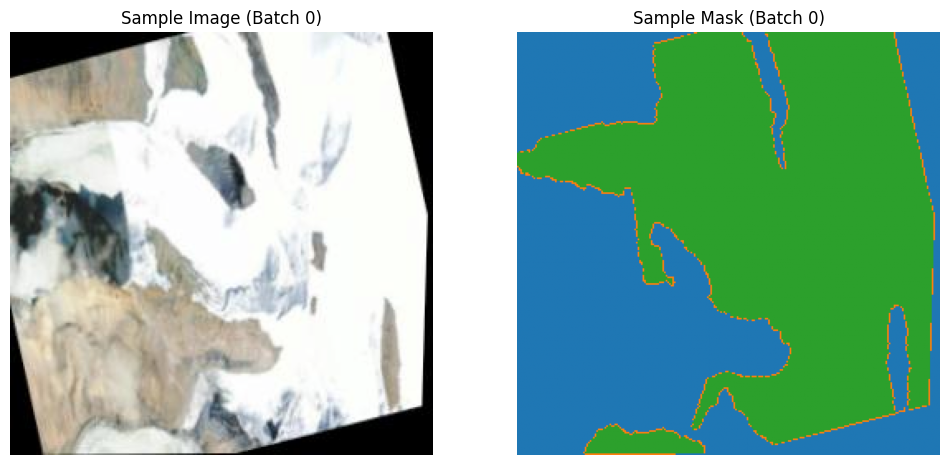

Unique labels in the visualized mask: [0 1 2]


In [8]:
images, masks = next(iter(train_loader))

print(f"\n--- Visualizing a Sample Batch ---")
print(f"Image batch shape: {images.shape}")  # [Batch Size, Channels, Height, Width]
print(f"Mask batch shape: {masks.shape}")    # [Batch Size, Height, Width]
print(f"Mask data type: {masks.dtype}")      # Should be torch.int64 (Long)

# Function to reverse the normalization for display
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().permute(1, 2, 0) # C, H, W -> H, W, C
    tensor = tensor * torch.tensor(std) + torch.tensor(mean)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

# Plot the first image and mask in the batch
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the image
ax[0].imshow(denormalize(images[0]))
ax[0].set_title(f"Sample Image (Batch 0)")
ax[0].axis('off')

# Display the mask
# We use a colormap to better visualize the different class labels
ax[1].imshow(masks[0], cmap='tab10', vmin=0, vmax=9) 
ax[1].set_title(f"Sample Mask (Batch 0)")
ax[1].axis('off')

plt.show()

# Display unique values in the first mask of the batch to confirm
unique_vals_in_batch_mask = torch.unique(masks[0])
print(f"Unique labels in the visualized mask: {unique_vals_in_batch_mask.numpy()}")